In [1]:
# Cell 1: Imports and Setup
import sys
from pathlib import Path

project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import load_npz
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


In [2]:
# Cell 2: Load saved features

processed_dir = project_root / 'data' / 'processed'

# Load metadata
df_shows = pd.read_csv(processed_dir / 'shows_metadata.csv')
print(f"Loaded {len(df_shows)} shows")

# Load feature matrices
genre_features = np.load(processed_dir / 'genre_features.npy')
text_features = load_npz(processed_dir / 'text_features.npz')
platform_features = np.load(processed_dir / 'platform_features.npy')
type_features = np.load(processed_dir / 'type_features.npy')
language_features = np.load(processed_dir / 'language_features.npy')

print("\nFeature shapes:")
print(f"  Genre: {genre_features.shape}")
print(f"  Text: {text_features.shape}")
print(f"  Platform: {platform_features.shape}")
print(f"  Type: {type_features.shape}")
print(f"  Language: {language_features.shape}")

Loaded 100 shows

Feature shapes:
  Genre: (100, 20)
  Text: (100, 500)
  Platform: (100, 21)
  Type: (100, 3)
  Language: (100, 3)


In [3]:
# Cell 3: Compute Genre Similarity (Jaccard-based)

print("="*50)
print("COMPUTING GENRE SIMILARITY")
print("="*50)

# Cosine similarity works well for multi-hot encoded genres
# (equivalent to Jaccard for binary features when normalized)
genre_similarity = cosine_similarity(genre_features)

print(f"Genre similarity matrix shape: {genre_similarity.shape}")
print(f"Similarity range: [{genre_similarity.min():.3f}, {genre_similarity.max():.3f}]")

# Example: Find shows similar to first show by genre
show_idx = 0
show_name = df_shows.iloc[show_idx]['name']
show_genres = df_shows.iloc[show_idx]['genres']

# Get top 10 most similar shows
similar_indices = np.argsort(genre_similarity[show_idx])[::-1][1:11]  # Exclude self

print(f"\nTop 10 shows similar to '{show_name}' by genre:")
print(f"Original genres: {show_genres}")
for i, idx in enumerate(similar_indices, 1):
    sim_score = genre_similarity[show_idx, idx]
    sim_name = df_shows.iloc[idx]['name']
    sim_genres = df_shows.iloc[idx]['genres']
    print(f"{i}. {sim_name} (score: {sim_score:.3f})")
    print(f"   Genres: {sim_genres}")

COMPUTING GENRE SIMILARITY
Genre similarity matrix shape: (100, 100)
Similarity range: [0.000, 1.000]

Top 10 shows similar to 'Under the Dome' by genre:
Original genres: ['Drama', 'Science-Fiction', 'Thriller']
1. The Lottery (score: 1.000)
   Genres: ['Drama', 'Science-Fiction', 'Thriller']
2. Orphan Black (score: 1.000)
   Genres: ['Drama', 'Science-Fiction', 'Thriller']
3. Utopia (score: 1.000)
   Genres: ['Drama', 'Science-Fiction', 'Thriller']
4. Scandal (score: 0.816)
   Genres: ['Drama', 'Thriller']
5. Homeland (score: 0.667)
   Genres: ['Drama', 'Thriller', 'Espionage']
6. Arrow (score: 0.667)
   Genres: ['Drama', 'Action', 'Science-Fiction']
7. Legends (score: 0.667)
   Genres: ['Drama', 'Crime', 'Thriller']
8. True Detective (score: 0.667)
   Genres: ['Drama', 'Crime', 'Thriller']
9. Scorpion (score: 0.667)
   Genres: ['Drama', 'Action', 'Thriller']
10. Resurrection (score: 0.667)
   Genres: ['Drama', 'Science-Fiction', 'Mystery']


In [4]:
# Cell 4: Compute Text Similarity (Cosine on TF-IDF)

print("="*50)
print("COMPUTING TEXT SIMILARITY")
print("="*50)

# Cosine similarity on TF-IDF vectors
text_similarity = cosine_similarity(text_features)

print(f"Text similarity matrix shape: {text_similarity.shape}")
print(f"Similarity range: [{text_similarity.min():.3f}, {text_similarity.max():.3f}]")

# Example: Find shows similar to first show by text
show_idx = 0
show_name = df_shows.iloc[show_idx]['name']
show_summary = df_shows.iloc[show_idx]['summary_clean'][:200]

similar_indices = np.argsort(text_similarity[show_idx])[::-1][1:11]

print(f"\nTop 10 shows similar to '{show_name}' by text:")
print(f"Summary preview: {show_summary}...")
print()
for i, idx in enumerate(similar_indices, 1):
    sim_score = text_similarity[show_idx, idx]
    sim_name = df_shows.iloc[idx]['name']
    print(f"{i}. {sim_name} (score: {sim_score:.3f})")

COMPUTING TEXT SIMILARITY
Text similarity matrix shape: (100, 100)
Similarity range: [0.000, 1.000]

Top 10 shows similar to 'Under the Dome' by text:
Summary preview: Under the Dome is the story of a small town that is suddenly and inexplicably sealed off from the rest of the world by an enormous transparent dome. The town's inhabitants must deal with surviving the...

1. Hemlock Grove (score: 0.307)
2. Haven (score: 0.307)
3. Witches of East End (score: 0.189)
4. True Blood (score: 0.158)
5. Sleepy Hollow (score: 0.144)
6. Resurrection (score: 0.142)
7. The Simpsons (score: 0.124)
8. Bitten (score: 0.118)
9. Falling Skies (score: 0.111)
10. Vikings (score: 0.101)


In [5]:
# Cell 5: Compute Metadata Similarity (Platform + Type + Language)

print("="*50)
print("COMPUTING METADATA SIMILARITY")
print("="*50)

# Combine platform, type, and language features
metadata_features = np.hstack([
    platform_features,
    type_features,
    language_features
])

metadata_similarity = cosine_similarity(metadata_features)

print(f"Metadata similarity matrix shape: {metadata_similarity.shape}")
print(f"Similarity range: [{metadata_similarity.min():.3f}, {metadata_similarity.max():.3f}]")

COMPUTING METADATA SIMILARITY
Metadata similarity matrix shape: (100, 100)
Similarity range: [0.000, 1.000]


In [6]:
# Cell 6: Combine similarities with different weights

print("="*50)
print("COMPUTING HYBRID SIMILARITY")
print("="*50)

# Experiment with different weighting schemes
def compute_hybrid_similarity(genre_weight, text_weight, metadata_weight):
    """Compute weighted combination of similarities"""

    # Normalize weights
    total = genre_weight + text_weight + metadata_weight
    genre_w = genre_weight / total
    text_w = text_weight / total
    metadata_w = metadata_weight / total

    hybrid_sim = (
        genre_w * genre_similarity +
        text_w * text_similarity +
        metadata_w * metadata_similarity
    )

    return hybrid_sim

# Try different weighting schemes
weighting_schemes = {
    "Balanced": (1, 1, 1),
    "Text-Heavy": (0.3, 0.6, 0.1),
    "Genre-Heavy": (0.6, 0.3, 0.1),
    "Text+Genre": (0.4, 0.5, 0.1),
    "No Metadata": (0.5, 0.5, 0.0),
}

# Compute similarities for each scheme
hybrid_similarities = {}
for scheme_name, (g, t, m) in weighting_schemes.items():
    hybrid_similarities[scheme_name] = compute_hybrid_similarity(g, t, m)
    print(f"{scheme_name:15} (G:{g}, T:{t}, M:{m})")

print("\n✓ Computed hybrid similarities for all schemes")

COMPUTING HYBRID SIMILARITY
Balanced        (G:1, T:1, M:1)
Text-Heavy      (G:0.3, T:0.6, M:0.1)
Genre-Heavy     (G:0.6, T:0.3, M:0.1)
Text+Genre      (G:0.4, T:0.5, M:0.1)
No Metadata     (G:0.5, T:0.5, M:0.0)

✓ Computed hybrid similarities for all schemes


In [7]:
# Cell 7: Compare weighting schemes for a specific show

show_idx = 0  # Change this to test different shows
show_name = df_shows.iloc[show_idx]['name']
show_genres = df_shows.iloc[show_idx]['genres']

print("="*50)
print(f"COMPARING RECOMMENDATIONS FOR: {show_name}")
print("="*50)
print(f"Genres: {show_genres}\n")

for scheme_name, similarity_matrix in hybrid_similarities.items():
    print(f"\n{scheme_name} scheme:")
    print("-" * 40)

    # Get top 5 similar shows
    similar_indices = np.argsort(similarity_matrix[show_idx])[::-1][1:6]

    for i, idx in enumerate(similar_indices, 1):
        sim_score = similarity_matrix[show_idx, idx]
        sim_name = df_shows.iloc[idx]['name']
        sim_genres = df_shows.iloc[idx]['genres']
        print(f"{i}. {sim_name} ({sim_score:.3f}) - {sim_genres}")

COMPARING RECOMMENDATIONS FOR: Under the Dome
Genres: ['Drama', 'Science-Fiction', 'Thriller']


Balanced scheme:
----------------------------------------
1. Utopia (0.583) - ['Drama', 'Science-Fiction', 'Thriller']
2. Orphan Black (0.573) - ['Drama', 'Science-Fiction', 'Thriller']
3. Scorpion (0.570) - ['Drama', 'Action', 'Thriller']
4. The Lottery (0.562) - ['Drama', 'Science-Fiction', 'Thriller']
5. Hemlock Grove (0.547) - ['Drama', 'Horror', 'Thriller']

Text-Heavy scheme:
----------------------------------------
1. Hemlock Grove (0.451) - ['Drama', 'Horror', 'Thriller']
2. Utopia (0.416) - ['Drama', 'Science-Fiction', 'Thriller']
3. Orphan Black (0.399) - ['Drama', 'Science-Fiction', 'Thriller']
4. The Lottery (0.378) - ['Drama', 'Science-Fiction', 'Thriller']
5. Resurrection (0.352) - ['Drama', 'Science-Fiction', 'Mystery']

Genre-Heavy scheme:
----------------------------------------
1. Utopia (0.691) - ['Drama', 'Science-Fiction', 'Thriller']
2. Orphan Black (0.683) - ['Drama',

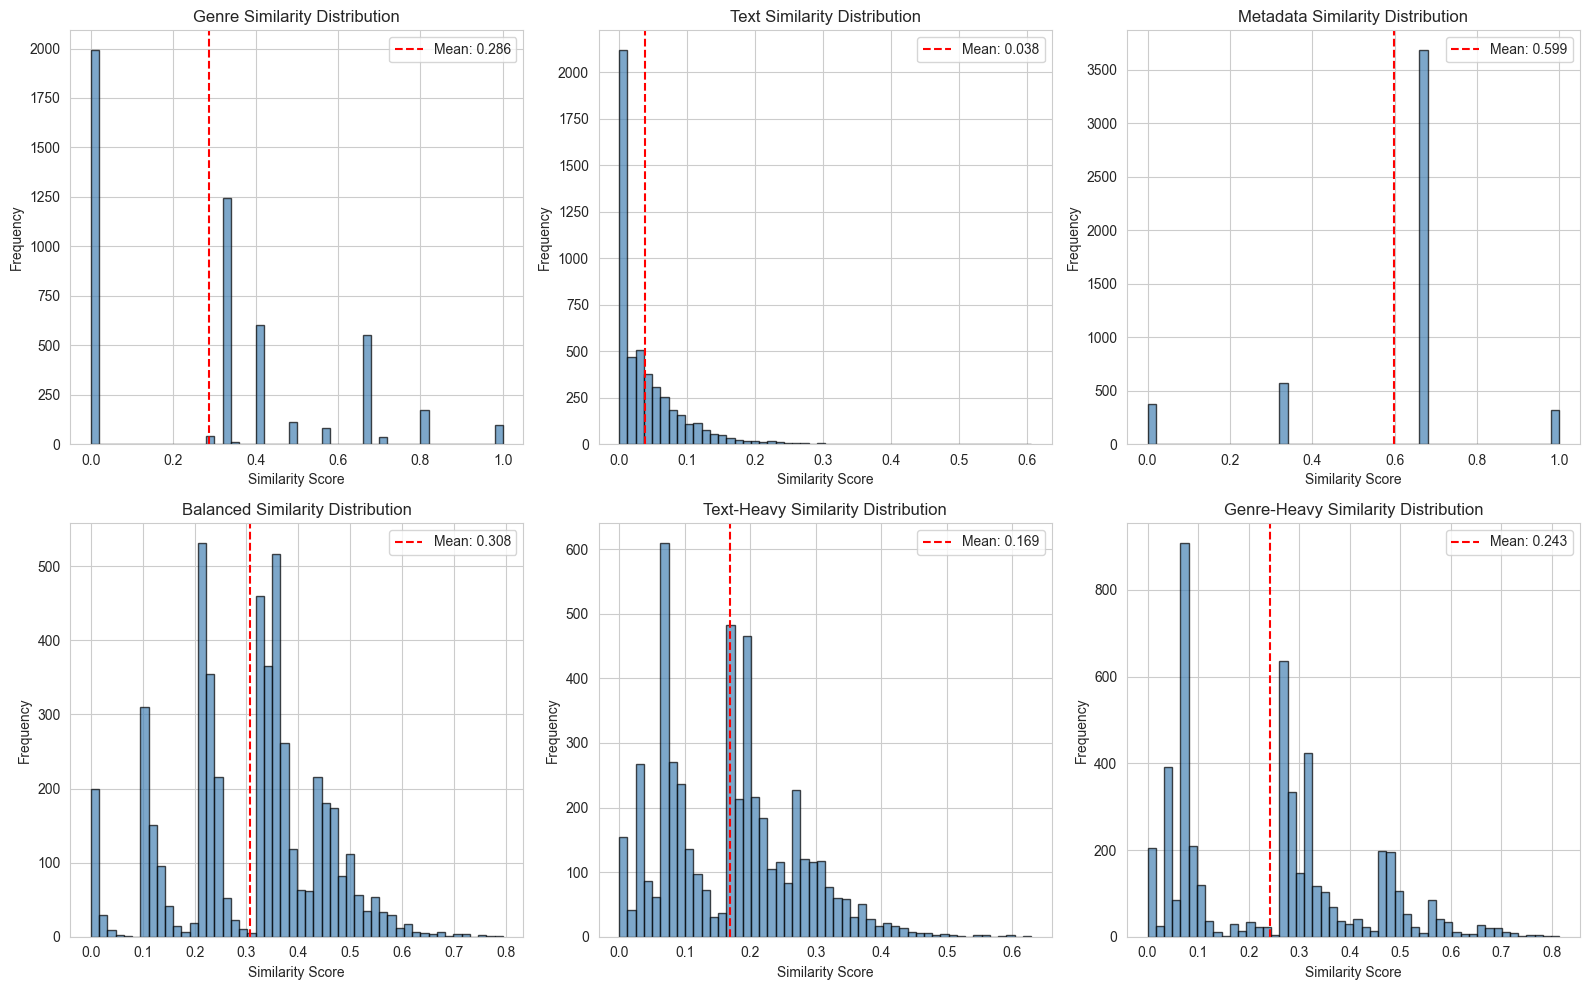

In [8]:
# Cell 8: Visualize similarity distributions

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

similarity_matrices = [
    ("Genre", genre_similarity),
    ("Text", text_similarity),
    ("Metadata", metadata_similarity),
    ("Balanced", hybrid_similarities["Balanced"]),
    ("Text-Heavy", hybrid_similarities["Text-Heavy"]),
    ("Genre-Heavy", hybrid_similarities["Genre-Heavy"])
]

for idx, (name, sim_matrix) in enumerate(similarity_matrices):
    # Get upper triangle (exclude diagonal and duplicates)
    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

    axes[idx].hist(upper_triangle, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('Similarity Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{name} Similarity Distribution')
    axes[idx].axvline(upper_triangle.mean(), color='red', linestyle='--',
                      label=f'Mean: {upper_triangle.mean():.3f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [9]:
# Cell 9: Analyze similarity statistics

print("="*50)
print("SIMILARITY STATISTICS")
print("="*50)

for name, sim_matrix in similarity_matrices:
    # Get upper triangle (exclude diagonal)
    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

    print(f"\n{name} Similarity:")
    print(f"  Mean: {upper_triangle.mean():.4f}")
    print(f"  Std:  {upper_triangle.std():.4f}")
    print(f"  Min:  {upper_triangle.min():.4f}")
    print(f"  Max:  {upper_triangle.max():.4f}")
    print(f"  Median: {np.median(upper_triangle):.4f}")

SIMILARITY STATISTICS

Genre Similarity:
  Mean: 0.2861
  Std:  0.2744
  Min:  0.0000
  Max:  1.0000
  Median: 0.3333

Text Similarity:
  Mean: 0.0381
  Std:  0.0517
  Min:  0.0000
  Max:  0.6060
  Median: 0.0216

Metadata Similarity:
  Mean: 0.5987
  Std:  0.2217
  Min:  0.0000
  Max:  1.0000
  Median: 0.6667

Balanced Similarity:
  Mean: 0.3076
  Std:  0.1376
  Min:  0.0000
  Max:  0.7940
  Median: 0.3333

Text-Heavy Similarity:
  Mean: 0.1686
  Std:  0.1019
  Min:  0.0000
  Max:  0.6292
  Median: 0.1667

Genre-Heavy Similarity:
  Mean: 0.2429
  Std:  0.1760
  Min:  0.0000
  Max:  0.8146
  Median: 0.2667


In [10]:
# Cell 10: Generate recommendations function

def get_recommendations(show_id, similarity_matrix, n=10, min_similarity=0.0):
    """
    Get top N recommendations for a show

    Args:
        show_id: ID of the show
        similarity_matrix: Similarity matrix to use
        n: Number of recommendations
        min_similarity: Minimum similarity threshold

    Returns:
        DataFrame with recommendations
    """
    # Find show index
    show_idx = df_shows[df_shows['id'] == show_id].index[0]

    # Get similarity scores
    sim_scores = similarity_matrix[show_idx]

    # Get indices of most similar shows (excluding self)
    similar_indices = np.argsort(sim_scores)[::-1][1:]

    # Filter by minimum similarity
    similar_indices = [idx for idx in similar_indices if sim_scores[idx] >= min_similarity]

    # Take top N
    similar_indices = similar_indices[:n]

    # Create recommendations dataframe
    recommendations = []
    for idx in similar_indices:
        recommendations.append({
            'show_id': df_shows.iloc[idx]['id'],
            'name': df_shows.iloc[idx]['name'],
            'genres': df_shows.iloc[idx]['genres'],
            'rating': df_shows.iloc[idx]['rating_avg'],
            'similarity_score': sim_scores[idx]
        })

    return pd.DataFrame(recommendations)

# Test the function
test_show_id = df_shows.iloc[0]['id']
test_show_name = df_shows.iloc[0]['name']

print(f"Recommendations for: {test_show_name} (ID: {test_show_id})")
print("="*70)

recs = get_recommendations(test_show_id, hybrid_similarities["Text+Genre"], n=10)
print(recs.to_string(index=False))

Recommendations for: Under the Dome (ID: 1)
 show_id                        name                                   genres  rating  similarity_score
      64                      Utopia ['Drama', 'Science-Fiction', 'Thriller']     8.3          0.507369
      61                Orphan Black ['Drama', 'Science-Fiction', 'Thriller']     8.6          0.493425
      33               Hemlock Grove          ['Drama', 'Horror', 'Thriller']     7.0          0.487054
      50                 The Lottery ['Drama', 'Science-Fiction', 'Thriller']     6.5          0.476503
      39                Resurrection  ['Drama', 'Science-Fiction', 'Mystery']     7.1          0.404546
      98                     Scandal                    ['Drama', 'Thriller']     7.9          0.393265
      95               Falling Skies   ['Drama', 'Action', 'Science-Fiction']     7.6          0.388662
      44                    Scorpion          ['Drama', 'Action', 'Thriller']     7.3          0.387713
      52 How to Get 

In [11]:
# Cell 11: Test recommendations for multiple shows

print("="*50)
print("TESTING RECOMMENDATIONS ON VARIOUS SHOWS")
print("="*50)

# Test on shows with different characteristics
test_shows = [
    ("Breaking Bad", "Drama/Crime show"),
    ("The Big Bang Theory", "Sitcom"),
    ("Game of Thrones", "Fantasy epic"),
]

for show_name, description in test_shows:
    # Find show
    show_row = df_shows[df_shows['name'].str.contains(show_name, case=False, na=False)]

    if len(show_row) == 0:
        print(f"\n'{show_name}' not found in dataset")
        continue

    show_id = show_row.iloc[0]['id']
    actual_name = show_row.iloc[0]['name']
    genres = show_row.iloc[0]['genres']

    print(f"\n{actual_name} ({description})")
    print(f"Genres: {genres}")
    print("-" * 70)

    recs = get_recommendations(show_id, hybrid_similarities["Text+Genre"], n=5)
    for i, row in recs.iterrows():
        print(f"{i+1}. {row['name']} ({row['similarity_score']:.3f}) - {row['genres']}")

TESTING RECOMMENDATIONS ON VARIOUS SHOWS

'Breaking Bad' not found in dataset

The Big Bang Theory (Sitcom)
Genres: ['Comedy']
----------------------------------------------------------------------
1. A to Z (0.442) - ['Comedy', 'Romance']
2. Manhattan Love Story (0.405) - ['Comedy', 'Romance']
3. New Girl (0.401) - ['Comedy', 'Romance']
4. Californication (0.377) - ['Drama', 'Comedy']
5. Bad Judge (0.375) - ['Comedy', 'Family']

Game of Thrones (Fantasy epic)
Genres: ['Drama', 'Adventure', 'Fantasy']
----------------------------------------------------------------------
1. Once Upon a Time in Wonderland (0.500) - ['Drama', 'Adventure', 'Fantasy']
2. Intruders (0.390) - ['Drama', 'Fantasy', 'Thriller']
3. Witches of East End (0.357) - ['Drama', 'Fantasy', 'Romance']
4. Vikings (0.334) - ['Drama', 'Action', 'History']
5. Lost Girl (0.333) - ['Drama', 'Fantasy', 'Horror']


In [12]:
# Cell 12: Save similarity matrices

print("="*50)
print("SAVING SIMILARITY MATRICES")
print("="*50)

# Save individual similarity matrices
np.save(processed_dir / 'genre_similarity.npy', genre_similarity)
print("✓ Saved genre similarity")

np.save(processed_dir / 'text_similarity.npy', text_similarity)
print("✓ Saved text similarity")

np.save(processed_dir / 'metadata_similarity.npy', metadata_similarity)
print("✓ Saved metadata similarity")

# Save best hybrid similarity (you can choose which one)
best_hybrid = hybrid_similarities["Text+Genre"]
np.save(processed_dir / 'hybrid_similarity.npy', best_hybrid)
print("✓ Saved hybrid similarity (Text+Genre)")

print("\n✓ All similarity matrices saved!")

SAVING SIMILARITY MATRICES
✓ Saved genre similarity
✓ Saved text similarity
✓ Saved metadata similarity
✓ Saved hybrid similarity (Text+Genre)

✓ All similarity matrices saved!


In [13]:
# Cell 13: Summary and Next Steps

print("="*50)
print("CONTENT SIMILARITY COMPUTATION COMPLETE")
print("="*50)

print(f"\n✓ Computed similarities for {len(df_shows)} shows")
print(f"✓ Tested {len(weighting_schemes)} weighting schemes")
print(f"✓ Generated and validated recommendations")

print("\nBest weighting scheme (subjective):")
print("  'Text+Genre' (40% genre, 50% text, 10% metadata)")
print("  - Balances thematic similarity with plot/tone matching")
print("  - Includes some network/type information")

print("\nNext steps:")
print("1. Set up MLflow to track experiments")
print("2. Implement evaluation metrics")
print("3. Store recommendations in database")
print("4. Deploy as Azure Function")

CONTENT SIMILARITY COMPUTATION COMPLETE

✓ Computed similarities for 100 shows
✓ Tested 5 weighting schemes
✓ Generated and validated recommendations

Best weighting scheme (subjective):
  'Text+Genre' (40% genre, 50% text, 10% metadata)
  - Balances thematic similarity with plot/tone matching
  - Includes some network/type information

Next steps:
1. Set up MLflow to track experiments
2. Implement evaluation metrics
3. Store recommendations in database
4. Deploy as Azure Function
